Let's start here! If you can directly link to an image relevant to your notebook, such as [canonical logos](https://github.com/numpy/numpy/blob/main/doc/source/_static/numpylogo.svg), do so here at the top of your notebook. You can do this with Markdown syntax,

![<Caribbeans for Climate>](CFC_logo.PNG "image alt text")

or edit this cell to see raw HTML `img` demonstration. This is preferred if you need to shrink your embedded image. **Either way be sure to include `alt` text for any embedded images to make your content more accessible.**

<img src="./images/icons/favicon.ico" width="250" alt="favicon logo"></img>

## Caribbean precipitation extremes and linear trends using HighResMIP

---

## Overview

In this notebook, we'll do the following:
- Learn how to make subregional-scale plots with the CMIP6 model output
- Plot spatial trends in summertime environmental variables
- Calculate the genesis potential index (GPI), an indicator of environmental favorability for tropical cyclogenesis


## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Load CMIP6 data with Intake-ESM](https://projectpythia.org/cmip6-cookbook/notebooks/foundations/intake-esm.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 30 minutes.


---

## Installs

Before you start, install the [xMIP](https://github.com/jbusecke/xMIP), [regionmask](https://regionmask.readthedocs.io/en/stable/index.html), and [tcpyPI](https://github.com/dgilford/tcpyPI/tree/master) packages. These packages allow us to mask and handle the bulky CMIP6 model output with ease. ```tcpyPI``` helps us calculate the potential intensity of storms given certain environmental conditions. Remove ```-q``` below for ```pip install``` output.


In [5]:
# !pip install -q git+https://github.com/jbusecke/xmip.git

In [6]:
# !pip install -q regionmask==0.12.1

In [4]:
# !pip install -q tcpypi

## Imports
Begin your body of content with another `---` divider before continuing into this section, then remove this body text and populate the following code cell with all necessary Python imports **up-front**:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
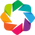

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import nc_time_axis
import regionmask
import bokeh
import intake
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
import holoviews as hv
import datashader
from holoviews.operation.datashader import regrid, shade, datashade

from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.ticker as mticker
import mpl_toolkits
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

hv.extension('bokeh', width=900)

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['figure.titlesize'] = 15
plt.rcParams["axes.titlesize"] = 15

In [8]:
# Define AxesGrid parameters for basemaps
projection = ccrs.PlateCarree()
mproj = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(projection=projection))

## Initiate compute cluster


In [9]:
import os
import sys
from tqdm.autonotebook import tqdm
from xhistogram.xarray import histogram
from dask_gateway import Gateway
from dask.distributed import Client


platform = sys.platform

if (platform == 'win32'):
    import multiprocessing.popen_spawn_win32
else:
    import multiprocessing.popen_spawn_posix

/tmp/ipykernel_990/552903533.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [10]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41433,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:44775,Total threads: 1
Dashboard: http://127.0.0.1:40613/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:38475,


Once you initiate your ```Client```, navigate to the ```Dask```![<Dask>](dask_icon_v2.ico "Dask logo") tab in the far-left sidebar or click the ```Launch dashboard in JupyterLab``` button above. In the search bar at the top, input your cluster's url. Then, replace ```https://127.0.0.1:``` with ```/proxy/```.

## Load the CMIP6 HighResMIP data

Since we're <ins>examining precipitation extremes at regional scales</ins>, it's good to use the highest resolution data available. In this notebook, we'll use the **HighResMIP experiments**, that provide a relatively higher resolution than the CMIP6 data. In this section, we'll choose one global climate model (as an example, NOAA GFDL's GFDL-CM4C192 model) for our analyses. We'll grab the following environmental variables:
- Omega (wap)
- Convective precipitation (prc)
- Mean sea-level pressure (psl)
- Eastward, Meridional (horizontal) winds (ua, va)
- Relative humidity (hur)
- Specific humidity (hus)

Below, we're using ```Intake-ESM``` to grab the model, experiments, and variables we want. ```Intake-ESM``` packages all of our data into two datasets (by experiment).

In [11]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


Use the column headers above to refine your catalog search.

In [12]:
cat = col.search(activity_id='HighResMIP', 
                 institution_id='NOAA-GFDL', 
                 experiment_id=['highresSST-present', 'highresSST-future'],
                 table_id='Amon',
                 variable_id=['psl', 'tas', 'wap', 'prc', 'hur', 'ua', 'va', 'hus'])

cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,wap,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
1,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,ua,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
2,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,psl,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
3,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,prc,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
4,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,hus,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
5,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,hur,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
6,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-future,r1i1p1f1,Amon,va,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
7,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-present,r1i1p1f1,Amon,prc,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
8,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-present,r1i1p1f1,Amon,hus,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701
9,HighResMIP,NOAA-GFDL,GFDL-CM4C192,highresSST-present,r1i1p1f1,Amon,hur,gr3,gs://cmip6/CMIP6/HighResMIP/NOAA-GFDL/GFDL-CM4...,NaN,20180701


In [13]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['HighResMIP.NOAA-GFDL.GFDL-CM4C192.highresSST-present.Amon.gr3',
 'HighResMIP.NOAA-GFDL.GFDL-CM4C192.highresSST-future.Amon.gr3']

We'll consolidate our catalog into two datasets, then merge with ```xarray.concat``` to create a larger dataset.

In [14]:
dsPRES = dset_dict['HighResMIP.NOAA-GFDL.GFDL-CM4C192.highresSST-present.Amon.gr3'].squeeze()
dsFUT = dset_dict['HighResMIP.NOAA-GFDL.GFDL-CM4C192.highresSST-future.Amon.gr3'].squeeze()
dsFULL = xr.concat([dsPRES, dsFUT], dim="time")
dsFULL

<xarray.Dataset> Size: 99GB
Dimensions:         (time: 1212, plev: 19, lat: 360, lon: 576, bnds: 2)
Coordinates:
  * bnds            (bnds) float64 16B 1.0 2.0
  * lat             (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    lat_bnds        (lat, bnds) float64 6kB -90.0 -89.5 -89.5 ... 89.5 89.5 90.0
  * lon             (lon) float64 5kB 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
    lon_bnds        (lon, bnds) float64 9kB 0.0 0.625 0.625 ... 359.4 360.0
  * plev            (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 500.0 100.0
  * time            (time) object 10kB 1950-01-16 12:00:00 ... 2050-12-16 12:...
    time_bnds       (time, bnds) object 19kB dask.array<chunksize=(780, 2), meta=np.ndarray>
    member_id       <U8 32B 'r1i1p1f1'
    dcpp_init_year  float64 8B nan
    height          float64 8B 2.0
Data variables:
    hur             (time, plev, lat, lon) float32 19GB dask.array<chunksize=(5, 19, 360, 576), meta=np.ndarray>
    hus             (time, plev, lat, lon) float32 19GB dask.array<chunksize=(5, 19, 360, 576), meta=np.ndarray>
    prc             (time, lat, lon) float32 1GB dask.array<chunksize=(85, 360, 576), meta=np.ndarray>
    psl             (time, lat, lon) float32 1GB dask.array<chunksize=(131, 360, 576), meta=np.ndarray>
    tas             (time, lat, lon) float32 1GB dask.array<chunksize=(112, 360, 576), meta=np.ndarray>
    ua              (time, plev, lat, lon) float32 19GB dask.array<chunksize=(4, 19, 360, 576), meta=np.ndarray>
    va              (time, plev, lat, lon) float32 19GB dask.array<chunksize=(4, 19, 360, 576), meta=np.ndarray>
    wap             (time, plev, lat, lon) float32 19GB dask.array<chunksize=(4, 19, 360, 576), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      HighResMIP
    branch_method:                    none provided
    branch_time_in_child:             0.0
    comment:                          <null ref>
    contact:                          gfdl.climate.model.info@noaa.gov
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gr3
    intake_esm_attrs:version:         20180701
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           HighResMIP.NOAA-GFDL.GFDL-CM4C192.highr...

## The global warming trend: Creating spatial trend maps

We understand that the Earth is warming from increasing linear trends in global mean surface temperatures. But, not everywhere warms at the same rate. This is known as the pattern effect, and it results in more complex global and regional climate change impacts. Using ```xarray```, we can find the linear trend at each gridpoint in our data.

Let's calculate the trend in precipitation over the Caribbean region.

AttributeError: 'DataArray' object has no attribute 'year'

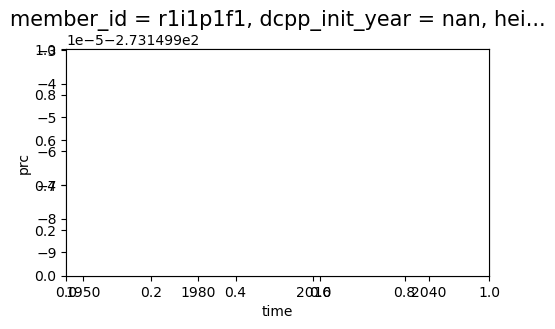

In [62]:
import matplotlib.gridspec as gridspec

# Calculate the global mean time series and linear trend from surface air temperatures
global_mean = dsFULL.prc.sel(time=dsFULL.time.dt.month.isin([8,9,10]), lat=slice(10, 30), lon=slice(260, 310)).mean(['lat', 'lon'])-273.15
da = global_mean.groupby('time.year')

# Use numpy lstsq to find linear trend
x = np.arange(0, global_mean.time.shape[0])
A = np.vstack([x, np.ones(len(x))]).T

# Calculate the least squares fit
m, c = np.linalg.lstsq(A, global_mean.values, rcond=None)[0]
gm_linear = m*x + c

# Calculate the linear trend at each grid point
res = da.polyfit(dim="year", deg=1)

# Plot results
fig = plt.figure(figsize=(12,10))

gs = gridspec.GridSpec(3, 2) 

ax1= fig.add_subplot(gs[0, :1])
ax2 = fig.add_subplot(gs[:1, :1])

# First subplot
global_mean.plot(ax=ax1, linewidth=1, color='black')
ax1.plot(global_mean.year.data, gm_linear, color='red')

# Second subplot
res[0].plot(ax=ax2, cmap=plt.cm.Reds)

## Let's take a look at our data

Let's plot some of our data to see how it looks. In the cell below, we take a sample of the data and resample from a monthly timescale to a 30-year (30YE) timescale.

/tmp/ipykernel_13850/595553653.py:11: MatplotlibDeprecationWarning: Passing an undefined label_mode is deprecated since 3.7 and will become an error two minor releases later. To silence this warning, pass "keep", which gives the same behaviour.
  axgr = AxesGrid(fig, 111, axes_class=axes_class,


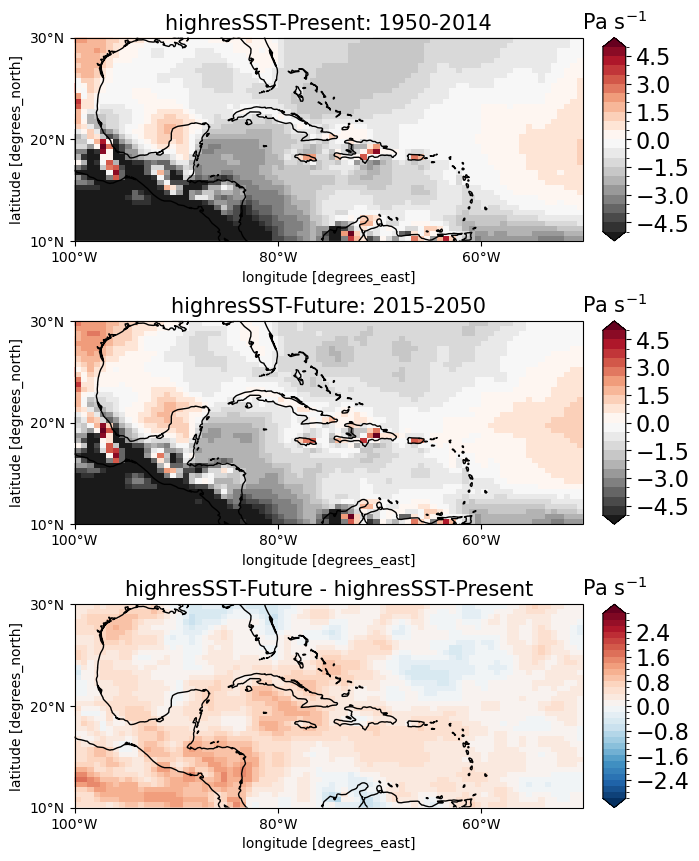

In [30]:
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

# Subset our data to only look at months August-October
da1_omega = dsPRES.wap.sel(time=dsPRES.time.dt.month.isin([8,9,10]), plev=500*100).mean('time')*1e2
da2_omega = dsFUT.wap.sel(time=dsFUT.time.dt.month.isin([8,9,10]), plev=500*100).mean('time')*1e2

difference = da2_omega - da1_omega

fig = plt.figure(figsize=(12,10))

axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 1),  # set subplots here
                axes_pad=0.8,
                cbar_location='right',
                cbar_mode='edge',
                cbar_pad=0.2,
                cbar_size='4.5%',
                label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    if i==0:
        ax.set_extent([-100, -50, 10, 30], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, zorder=2, facecolor='None', edgecolor='black')

        ax.set_xticks(np.arange(-100, -50, 20), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(10, 40, 10), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        
        fc = da1_omega.plot(levels=np.arange(-5, 5.5, 0.5), cmap=plt.cm.RdGy_r, extend='both', add_colorbar=False, ax=ax)
        ax.set_title("highresSST-Present: 1950-2014")

        cbar = plt.colorbar(fc, cax=axgr.cbar_axes[0], orientation='vertical')
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.set_title(r'Pa s$^{-1}$')

    if i==1:
        ax.set_extent([-100, -50, 10, 30], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, zorder=2, facecolor='None', edgecolor='black')

        ax.set_xticks(np.arange(-100, -50, 20), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(10, 40, 10), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        
        fc = da2_omega.plot(levels=np.arange(-5, 5.5, 0.5), cmap=plt.cm.RdGy_r, extend='both', add_colorbar=False, ax=ax)
        ax.set_title("highresSST-Future: 2015-2050")

        cbar = plt.colorbar(fc, cax=axgr.cbar_axes[1], orientation='vertical')
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.set_title(r'Pa s$^{-1}$')
        
    if i==2:
        ax.set_extent([-100, -50, 10, 30], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND, zorder=2, facecolor='None', edgecolor='black')

        ax.set_xticks(np.arange(-100, -50, 20), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(10, 40, 10), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        
        fc = difference.plot(levels=np.arange(-3, 3.2, 0.2), cmap=plt.cm.RdBu_r, extend='both', add_colorbar=False, ax=ax)
        ax.set_title("highresSST-Future - highresSST-Present")

        cbar = plt.colorbar(fc, cax=axgr.cbar_axes[2], orientation='vertical')
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.set_title(r'Pa s$^{-1}$')

## Calculating potential intensity with TCPyPI

## Calculating TCPyPI

Here, we'll do something a little different. We'll retrieve some more data above to calculate what is known as genesis potential for the Caribbean region. Genesis potential is an indicator of how favorable 

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Your relevant information here!
</div>

Feel free to copy this around and edit or play around with yourself. Some other `admonitions` you can put in:

<div class="admonition alert alert-success">
    <p class="admonition-title" style="font-weight:bold">Success</p>
    We got this done after all!
</div>

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Be careful!
</div>

<div class="admonition alert alert-danger">
    <p class="admonition-title" style="font-weight:bold">Danger</p>
    Scary stuff be here.
</div>

We also suggest checking out Jupyter Book's [brief demonstration](https://jupyterbook.org/content/metadata.html#jupyter-cell-tags) on adding cell tags to your cells in Jupyter Notebook, Lab, or manually. Using these cell tags can allow you to [customize](https://jupyterbook.org/interactive/hiding.html) how your code content is displayed and even [demonstrate errors](https://jupyterbook.org/content/execute.html#dealing-with-code-that-raises-errors) without altogether crashing our loyal army of machines!

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!